In [72]:
#Importing all necessary libraries for time series analysis and forecasting
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import pmdarima
from pmdarima import auto_arima
import seaborn as sns

In [73]:
#Function to get specific columns of data from the data frame
def get_certain_columns(df, columns):
    return df[columns]

#Function to get the best alpha value for the Ridge Regression
def best_alpha(x, y):
    alphas = np.arange(0.001, 0.05, 0.001)
    modelCV = RidgeCV(alphas = alphas, store_cv_values=True)
    modelCV.fit(x, y)
    return modelCV.alpha_

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=2.41437e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


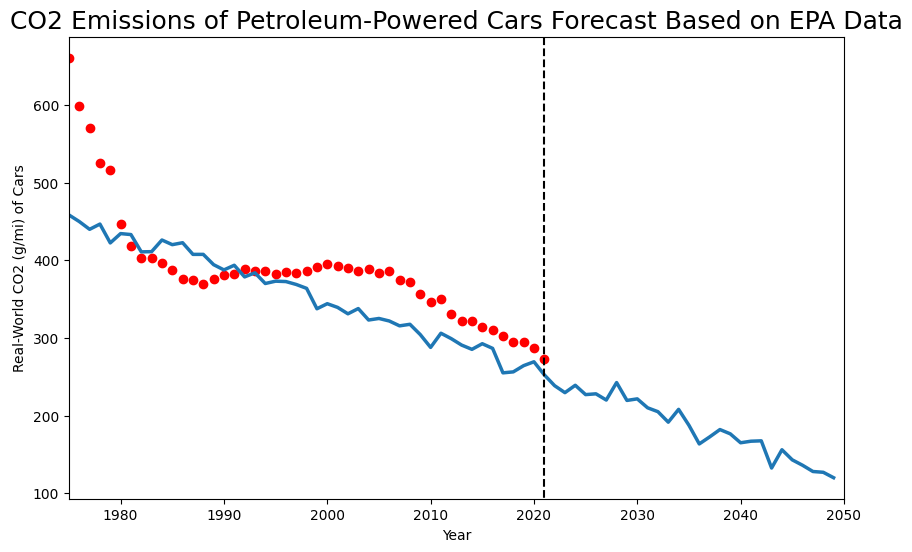

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=2.41437e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


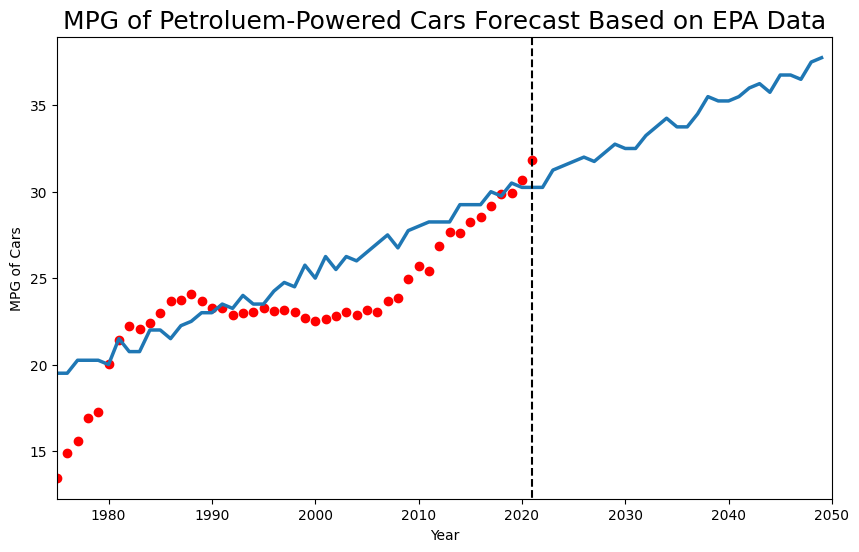

In [74]:
#Reading EPA Automotive Trends Report Database
data_EPA = pd.read_csv('United States Environmental Protection Agency – Automotive Trends Report.csv')

#Function that creates a graph for a specific vehicle type and a specific metric(column)
def get_specific_EPAgraph(vehicle_type, index, column, title, xlabel, ylabel):
    specific_data = pd.DataFrame(data_EPA.loc[data_EPA['Vehicle Type'] == vehicle_type].values.tolist())
    specific_data.columns = data_EPA.columns
    specific_data = specific_data[[index, column]]
    specific_data.set_index(index, inplace=True)
    specific_data = specific_data.iloc[:-1,:]
    yearsarray = np.array([int(i) for i in specific_data.index])
    x = yearsarray
    y_in = specific_data
    x_pred = []
    for i in range(1975,2050):
        x_pred.append(i)
    poly_features = x.reshape(-1,1)
    poly_reg_model = KernelRidge(alpha = 0.05, kernel = "polynomial", degree = 2)
    poly_reg_model.fit(poly_features, y_in)
    y_predicted = poly_reg_model.predict(poly_features)
    x_new = np.array(x_pred).reshape(-1,1)
    pred_new = poly_reg_model.predict(x_new)
    plt.figure(figsize=(10,6))
    plt.title(title, size=18)
    plt.plot(x_new, pred_new, linewidth = 2.5)
    plt.scatter(x, y_in, color = 'red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axvline(x=2021, ymin=-2.5, ymax = 9, color = 'black', linestyle = '--')
    plt.xlim([1975,2050])
    plt.ylim([0,1000])
    plt.autoscale(enable=True, axis='y', tight=False)
    plt.show()

#Calling the function for graphs of specific vehicle type and specific metric
index = 'Model Year'
get_specific_EPAgraph('All Car', index, 'Real-World CO2 (g/mi)',
    'CO2 Emissions of Petroleum-Powered Cars Forecast Based on EPA Data', 
    'Year', 'Real-World CO2 (g/mi) of Cars')
get_specific_EPAgraph('All Car', index, 'Real-World MPG', 
    'MPG of Petroluem-Powered Cars Forecast Based on EPA Data', 
    'Year', 'MPG of Cars')


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24032\1276842376.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crash_data['Date'] = pd.to_datetime(crash_data['CRASH_DATE'], format='%m/%d/%Y %H:%M:%S %p')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24032\1276842376.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crash_data['Year'] = crash_data['Date'].dt.year
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24032\1276842376.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping colum

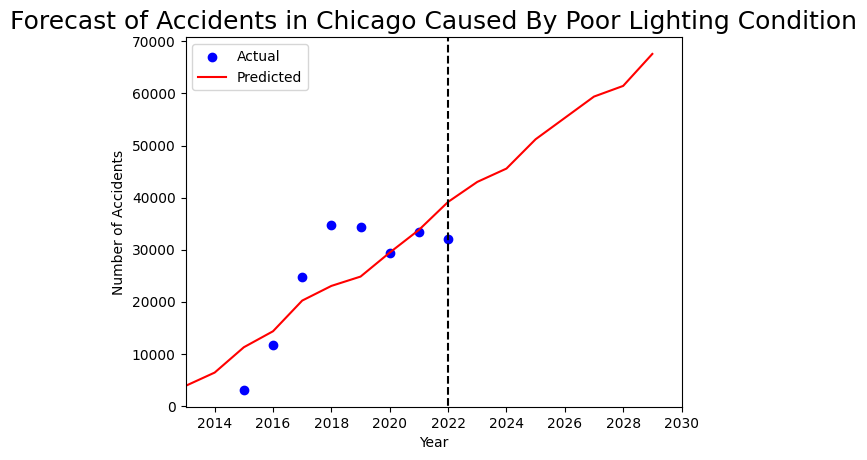

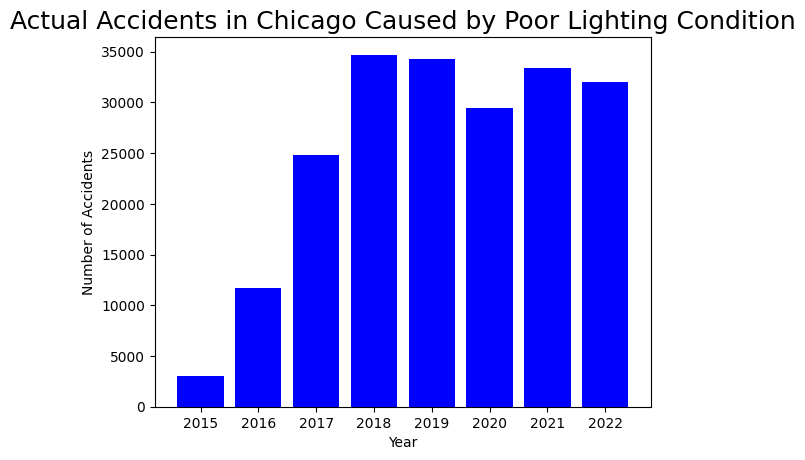

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24032\1276842376.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lighting_by_year = crash_data.groupby('Year').apply(lambda x: x[column].apply(check).sum())
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=7.55785e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


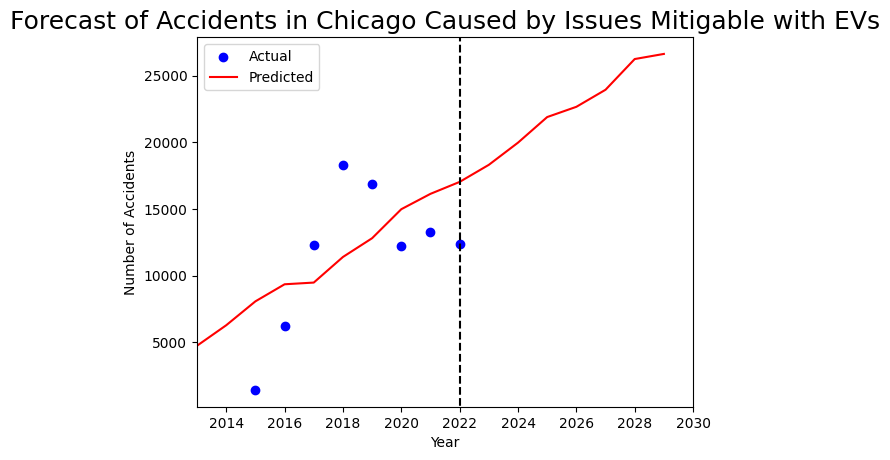

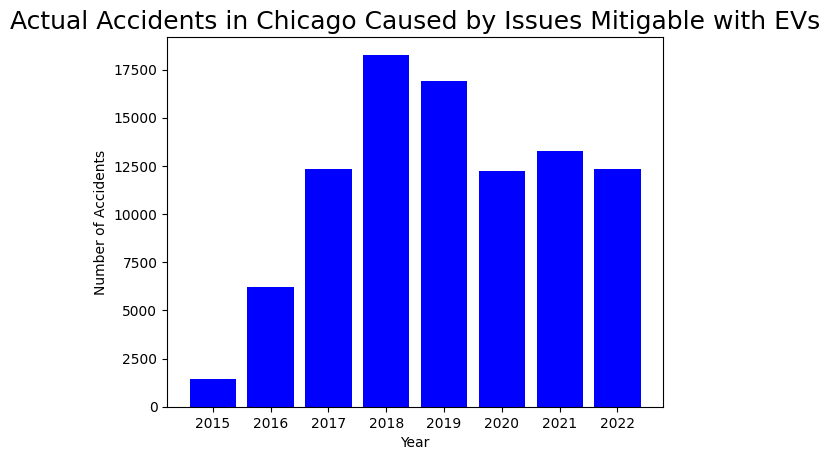

In [75]:
#Reading Chicago Crash Database
data_Chicago = pd.read_csv('City of Chicago Traffic Crashes - Crashes.csv')

#Getting required columns from dataset
crash_data = get_certain_columns(data_Chicago, ['CRASH_DATE', 
    'LIGHTING_CONDITION', 'PRIM_CONTRIBUTORY_CAUSE'])

#Creating Date column and Year column from CRASH_DATE
crash_data['Date'] = pd.to_datetime(crash_data['CRASH_DATE'], format='%m/%d/%Y %H:%M:%S %p')
crash_data['Year'] = crash_data['Date'].dt.year

#Function to plot crash data by year based on column and condition
def crash_graph(column, checkfor, graph_title_pred, graph_title):
    def check(x):
        if any (req in x for req in checkfor):
            return True
        return False
    lighting_by_year = crash_data.groupby('Year').apply(lambda x: x[column].apply(check).sum())
    x = np.array([int(i) for i in lighting_by_year.index[2:10]])
    y_in = lighting_by_year[2:10]
    x_pred = []
    for i in range(2013,2030):
        x_pred.append(i)
    poly_features = x.reshape(-1,1)
    poly_reg_model = KernelRidge(alpha = 0.0175, kernel = "polynomial", degree = 2)
    poly_reg_model.fit(poly_features, y_in)
    y_predicted = poly_reg_model.predict(poly_features)
    x_new = np.array(x_pred).reshape(-1,1)
    pred_new = poly_reg_model.predict(x_new)
    plt.scatter(lighting_by_year.index[2:10], lighting_by_year[2:10], color = 'blue', label = 'Actual')
    plt.plot( x_new, pred_new, color = 'red', label = 'Predicted')
    plt.title(graph_title_pred, size=18)
    plt.xlabel('Year')
    plt.ylabel('Number of Accidents')
    plt.axvline(x=2022, ymin=-2.5, ymax = 9, color = 'black', linestyle = '--')
    plt.xlim([2013,2030])
    plt.legend()
    plt.show()
    plt.bar( lighting_by_year.index[2:10], lighting_by_year[2:10], color = 'blue', label = 'Actual Data')
    plt.title(graph_title, size=18)
    plt.xlabel('Year')
    plt.ylabel('Number of Accidents')
    plt.show()

#Calling function to graph plots of different columns and different conditions
crash_graph('LIGHTING_CONDITION', ['DARKNESS', 'DUSK'], 
    'Forecast of Accidents in Chicago Caused By Poor Lighting Condition', 
    'Actual Accidents in Chicago Caused by Poor Lighting Condition')
crash_graph('PRIM_CONTRIBUTORY_CAUSE', 
    ['VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)', 'IMPROPER LANE USAGE', 
        'IMPROPER BACKING', 'FAILING TO REDUCE SPEED TO AVOID CRASH', 
        'EXCEEDING AUTHORIZED SPEED LIMIT', 'ROAD CONSTRUCTION/MAINTENANCE', 
        'EXCEEDING SAFE SPEED FOR CONDITIONS', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST'], 
    'Forecast of Accidents in Chicago Caused by Issues Mitigable with EVs', 
    'Actual Accidents in Chicago Caused by Issues Mitigable with EVs')

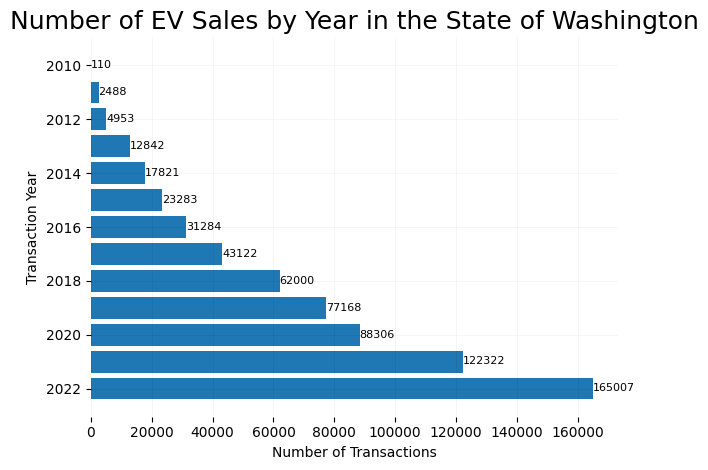

In [76]:
#Reading State of Washington Electric Vehicle Title and Registration Activity Database
data_WA_reg = pd.read_csv('State of Washington - Electric Vehicle Title and Registration Activity.csv')

#Calling function to get the column of Transaction Year
transaction_years = get_certain_columns(data_WA_reg, ['Transaction Year'])

#Finding unique years in the Transaction Year column
unique = {}
for number in transaction_years['Transaction Year'].unique():
    if number != 2023:
        unique[number] = transaction_years['Transaction Year'].value_counts()[number]

#Plotting a bar plot of the unique years and number of transactions per year
plt.barh(list(unique.keys()), list(unique.values()))

#Adding values to the bar plot
for i in plt.gca().patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(i.get_width()), fontsize=8)
    
#Formatting the plot
for s in ['top', 'bottom', 'left', 'right']:
    plt.gca().spines[s].set_visible(False)
plt.gca().grid(visible=True, color = 'black', linestyle='-', linewidth=0.5, alpha=0.05)
plt.gca().invert_yaxis()
plt.ylabel('Transaction Year')
plt.xlabel('Number of Transactions')
plt.title('Number of EV Sales by Year in the State of Washington', size=18)
plt.tight_layout()

plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24032\4051863794.py:5: DtypeWarning: Columns (7,16,62,64,65,67,68,78) have mixed types. Specify dtype option on import or set low_memory=False.
  data_EPA1 = pd.read_csv('United States Environmental Protection Agency – Vehicle Fuel Economy Estimates.csv')
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=3.66639e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


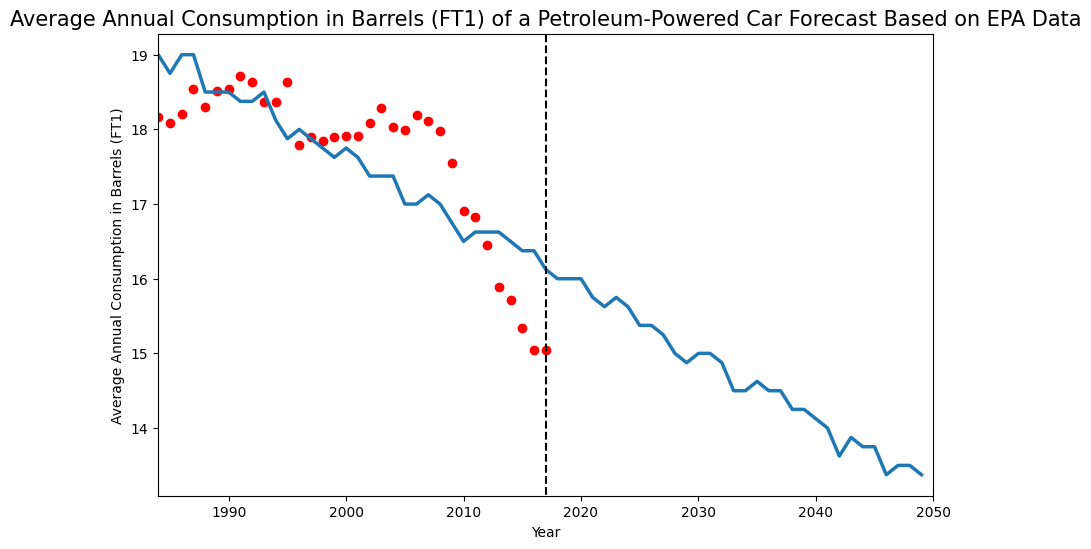

In [77]:
from enum import auto
from tracemalloc import start

#Reading EPA Fuel Economy Estimates Database
data_EPA1 = pd.read_csv('United States Environmental Protection Agency – Vehicle Fuel Economy Estimates.csv')

#Function which only allows Gas vehicle names to return True
def gas_only(name):
    if('Electricity' in name):
        return False
    if(('propane' in name) or ('CNG' in name) or ('natural gas' in name)):
        return False
    return True

#Getting only Year and Annual Consumption in Barrels columns of Gas vehicles
gas = pd.DataFrame(data_EPA1.loc[data_EPA1['Fuel Type'].apply(gas_only)].values.tolist())
gas.columns = data_EPA1.columns
gas = gas.loc[gas['Annual Consumption in Barrels (FT1)'] != '0']
gas = get_certain_columns(gas, ['Year', 'Annual Consumption in Barrels (FT1)'])

#Creating database of yearly averages in Annual Consumption in Barrels(FT1)
unique_values = {}
unique_years = gas['Year'].unique().tolist()
unique_years.sort()
for i in unique_years:
    n = gas.groupby('Year').get_group(i)['Annual Consumption in Barrels (FT1)'].count()
    unique_values[i] = gas.groupby('Year').get_group(i)['Annual Consumption in Barrels (FT1)'].sum()/n
df_dict = {'Year' : unique_values.keys(), 'Annual Consumption in Barrels (FT1)' : unique_values.values()}
gas = pd.DataFrame(df_dict)
gas.set_index('Year', inplace=True)
yearsarray = np.array([int(i) for i in gas.index])

#Creating Ridge Regression model to forecast Annual Consumption in Barrel(FT1)
x = yearsarray
y_in = gas
x_pred = []
for i in range(1984,2050):
    x_pred.append(i)
poly_features = x.reshape(-1,1)
poly_reg_model = KernelRidge(alpha = best_alpha(poly_features, y_in), kernel = "polynomial", degree = 2)
poly_reg_model.fit(poly_features, y_in)
y_predicted = poly_reg_model.predict(poly_features)
x_new = np.array(x_pred).reshape(-1,1)
pred_new = poly_reg_model.predict(x_new)

#Plotting regression line and actual data points
plt.figure(figsize=(10,6))
plt.title('Average Annual Consumption in Barrels (FT1) of a Petroleum-Powered Car Forecast Based on EPA Data', 
        size=15)
plt.plot(x_new, pred_new, linewidth = 2.5)
plt.scatter(x, y_in, color = 'red')
plt.xlabel('Year')
plt.ylabel('Average Annual Consumption in Barrels (FT1)')
plt.axvline(x=2017, ymin=-2.5, ymax = 9, color = 'black', linestyle = '--')
plt.xlim([1984,2050])
plt.ylim([0,1000])
plt.autoscale(enable=True, axis='y', tight=False)
plt.show()